# Precalculated data for Places for Half Earth Future
## AOI Summaries: Includes SPS calculations and new human pressures - March 2023 
In this notebook, we generate precalculated data for the layer `Places for Half Earth Future`. 
The biodiversity and contextual data were generated in ArcPro. The current precalculations include:
- Global SPS (from species lookup tables) 
- SPS values specific to the AOI (SPS_aoi): use biodiversity data found within the protected areas of each AOI. 
- New contextual data using human pressures time series

## Table of contents
1. [Setup](#setup)
    1. [Import libraries](#libraries)
    2. [Utils](#utils)
    3. [Connect to ESRI](#esri)
2. [Prepare data](#data)
3. [Simplification of geometries](#simplification)
3. [Calculate biodiversity](#biodiversity)
    1. [Calculate SPS_aoi](#spsaoi)
    2. [Format biodiversity table](#biotable)
    3. [Add nspecies](#nspecies)
4. [Contextual data](#contextual)
    1. [ELU, protection and population](#othercontextual)
    2. [Human pressures](#pressures)



<a id='setup'></a>
## Setup
<a id='libraries'></a>
### Import libraries

In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import arcgis
from arcgis.gis import GIS
import json
import pandas as pd
from arcgis.features import FeatureLayerCollection
import requests as re
from copy import deepcopy
from itertools import repeat
import functools


<a id='utils'></a>
### Utils

**getHTfromId**

In [3]:
def getHTfromId(item_id):
    item = gis.content.get(item_id)
    flayer = item.tables[0]
    sdf = flayer.query().sdf
    return sdf

**format_df**

In [24]:
def format_df(path, file_name, lookups_id):
    df = pd.read_csv(f'{path}/{file_name}')
    col_name = [col for col in df.columns if col in ['amphibians','birds','presence','reptiles']]
    df.rename(columns={'SliceNumbe':'SliceNumber',col_name[0]:'SUM'}, inplace=True)
    
    ### Get information from lookup tables:
    lookup = getHTfromId(lookups_id)
    df = df.merge(lookup[['SliceNumber','range_area_km2', 'SPS', 'conservation_target']], how='left',on = 'SliceNumber')
    
    ### Get species area against global species range:
    df['per_global'] = round(df['SUM']/df['range_area_km2']*100,2)
    df.loc[df['per_global']> 100,'per_global'] = 100 ### make max presence 100%
      
    return df


<a id='esri'></a>
### Connect to ArcGIS API

In [4]:
env_path = ".env"
with open(env_path) as f:
   env = {}
   for line in f:
       env_key, _val = line.split("=")
       env_value = _val.split("\n")[0]
       env[env_key] = env_value

In [5]:
aol_password = env['ARCGIS_SOFIA_PASS']
aol_username = env['ARCGIS_SOFIA_USER']

In [6]:
gis = GIS("https://eowilson.maps.arcgis.com", aol_username, aol_password, profile = "eowilson")

Keyring backend being used (keyring.backends.OS_X.Keyring (priority: 5)) either failed to install or is not recommended by the keyring project (i.e. it is not secure). This means you can not use stored passwords through GIS's persistent profiles. Note that extra system-wide steps must be taken on a Linux machine to use the python keyring module securely. Read more about this at the keyring API doc (http://bit.ly/2EWDP7B) and the ArcGIS API for Python doc (http://bit.ly/2CK2wG8).


<a id='data'></a>
### Prepare data

The geometries for the up to 20 places for the Half-Earth Future were sent by Scott Rinnan https://eowilson.maps.arcgis.com/home/item.html?id=358f2419c967453195ec72e4d910fd6e. The precalculations where done in ArcGIS Pro (project `Places_HE_Future`). However, 4 of the 1925 original geometries were removed during the process to extract the biodiversity data because they caused the sample tool to fail in ArcGIS Pro. The removed geometries are clusters (MOL_IDs) 62, 69, 73, 194.

In [7]:
path_in = '/Users/sofia/Documents/HE_Data/Precalculated/PlacesHE/Inputs'
path_out = '/Users/sofia/Documents/HE_Data/Precalculated/PlacesHE/Outputs'

In [10]:
# Import Scott's geometry converted to geojson
places= gpd.read_file(f'{path_in}/Geometries/Top_20_places_original/places20.geojson') 
len(places)

1925

In [11]:
places.head(1)

,OBJECTID,GID_0,NAME_0,cluster,PRmean,AREA_KM2,MOL_ID,Shape_Length,Shape_Area,geometry
0,1,AFG,Afghanistan,1,60.222222,7687.50492,1,442334.303716,1.124109e+10,"POLYGON ((7827944.398 4014125.022, 7829351.252..."


In [12]:
# Remove the geometries that we couldn't use in ArcGIS Pro
bad_geom = [62, 69, 73, 194]
places = places[~places['MOL_ID'].isin(bad_geom)]
len(places)

1921

In [13]:
# Check if the geometries are valid
sum(places.is_valid) # all geometries are valid

1921

In [14]:
places.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World - 85°S to 85°N
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [15]:
places_prj = places.to_crs(epsg=4326)
places_prj.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [16]:
# Save good geometries as geojson. This is the dataset that we are going to use later
places_prj.to_file(f"{path_in}/Geometries/Top_20_places_good_geom/places_good_geometries_aoi_summaries.geojson",driver='GeoJSON') 

<a id='simplification'></a>
## Simplification of geometries

In [18]:
# Only simplify (retains all geometries).
!mapshaper-xl 16gb -i /Users/sofia/Documents/HE_Data/Precalculated/PlacesHE/Inputs/Geometries/Top_20_places_good_geom/places_good_geometries_aoi_summaries.geojson snap \
    -simplify 20% weighting=0.7 planar keep-shapes \
    -o /Users/sofia/Documents/HE_Data/Precalculated/PlacesHE/Inputs/Geometries/Top_20_places_simplification/places_simplified_aoi_summaries.geojson format=geojson precision=0.001 id-field="MOL_ID"

Allocating 16 GB of heap memory
[i] Snapped 3 points
[simplify] Repaired 166 intersections; 459 intersections could not be repaired
[o] Wrote /Users/sofia/Documents/HE_Data/Precalculated/PlacesHE/Inputs/Geometries/Top_20_places_simplification/places_simplified_aoi_summaries.geojson


In [19]:
sim = gpd.read_file(f'{path_in}/Geometries/Top_20_places_simplification/places_simplified_aoi_summaries.geojson') # retains all geometries
len(sim)

1921

<AxesSubplot:>

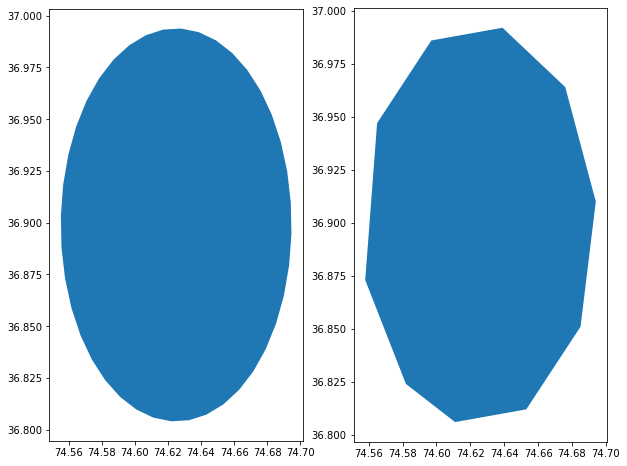

In [20]:
n= 18
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,10))
places_prj[places_prj['cluster']==n].geometry.plot(ax = ax1) 
sim[sim['cluster']==n].geometry.plot(ax = ax2)

<a id='biodiversity'></a>
## Format Biodiversity data

In [62]:
### Ids of lookup tables for each taxa in ArcGIS online
lookups = {'amphibians':'de2309ec6aa64223a8bea682c0200d34',
         'birds':'b5f5c8d693b74abd9b0d236915d8e739',
         'mammals':'1d3b50e3b8544730ae0e2a80f00b4119',
         'reptiles':'bc6de8b9b8df4fffb6aa4208f4bf1467'}

# Get data for all taxa
amphibians = format_df(path_in, 'Sample_amph_nozeroes.csv', lookups['amphibians'])
birds = format_df(path_in, 'Sample_birds_nozeroes.csv', lookups['birds'])
mammals = format_df(path_in, 'Sample_mammals_nozeroes.csv', lookups['mammals'])
reptiles = format_df(path_in, 'Sample_reptiles_nozeroes.csv', lookups['reptiles'])


In [63]:
# Change the column name SPS to SPS_global to differenciate it from the SPS_aoi we'll calculate later
amphibians = amphibians.rename(columns = {'SPS': 'SPS_global'}).drop(columns={'Dimensions', 'X', 'Y', 'OID_'})
birds = birds.rename(columns = {'SPS': 'SPS_global'}).drop(columns={'Dimensions', 'X', 'Y', 'OID_'})
mammals = mammals.rename(columns = {'SPS': 'SPS_global'}).drop(columns={'Dimensions', 'X', 'Y', 'OID_'})
reptiles = reptiles.rename(columns = {'SPS': 'SPS_global'}).drop(columns={'Dimensions', 'X', 'Y', 'OID_'})

In [64]:
amphibians

,MOL_ID,SUM,SliceNumber,range_area_km2,SPS_global,conservation_target,per_global
0,124,34.0,819.0,993447,100,15,0.00
1,124,1257.0,956.0,2107415,100,15,0.06
2,124,2758.0,963.0,8973505,95,15,0.03
3,124,1515.0,2340.0,3276642,100,15,0.05
4,124,2883.0,2764.0,1013067,100,15,0.28
...,...,...,...,...,...,...,...
36954,344,3174.0,4603.0,372935,29,15,0.85
36955,344,9288.0,5306.0,847597,1,15,1.10
36956,344,6279.0,5359.0,683149,3,15,0.92
36957,344,9402.0,5423.0,846723,5,15,1.11


<a id='spsaoi'></a>
### Calculate SPS_aoi

In [66]:
# To calculate the SPS_AOI we need to know the species found on the WDPAs (calculations done in Pro: AOI_Summaries_Precalculations.aprx)
wdpa_amph = pd.read_csv(f'{path_in}/WDPA_Places/Amphibians_wdpa_places.csv').drop(columns={'Dimensions', 'X', 'Y', 'OID_'}).astype(int).rename(columns={'amphibians': 'SUM_PA'})
wdpa_bird = pd.read_csv(f'{path_in}/WDPA_Places/Birds_wdpa_places.csv').drop(columns={'Dimensions', 'X', 'Y', 'OID_'}).astype(int).rename(columns={'birds': 'SUM_PA'})
wdpa_mamm = pd.read_csv(f'{path_in}/WDPA_Places/Mammals_wdpa_places.csv').drop(columns={'Dimensions', 'X', 'Y', 'OID_'}).astype(int).rename(columns={'presence': 'SUM_PA'})
wdpa_rept = pd.read_csv(f'{path_in}/WDPA_Places/Reptiles_wdpa_places.csv').drop(columns={'Dimensions', 'X', 'Y', 'OID_'}).astype(int).rename(columns={'reptiles': 'SUM_PA'})

In [67]:
wdpa_amph.head(1)

,MOL_ID,SUM_PA,SliceNumber,PLACES_ID
0,171618,1,1700,1547


In [68]:
# Aggregate data by place: Aggregate species (SliceNumber) located in different WDPA (MOL_ID) belonging to the same place (PLACES_ID)
wdpa_amph2 = wdpa_amph[['PLACES_ID', 'SliceNumber', 'SUM_PA']]
wdpa_amph2 = wdpa_amph2.groupby(['PLACES_ID', 'SliceNumber']).sum().reset_index()
wdpa_bird2 = wdpa_bird[['PLACES_ID', 'SliceNumber', 'SUM_PA']]
wdpa_bird2 = wdpa_bird2.groupby(['PLACES_ID', 'SliceNumber']).sum().reset_index()
wdpa_mamm2 = wdpa_mamm[['PLACES_ID', 'SliceNumber', 'SUM_PA']]
wdpa_mamm2 = wdpa_mamm2.groupby(['PLACES_ID', 'SliceNumber']).sum().reset_index()
wdpa_rept2 = wdpa_rept[['PLACES_ID', 'SliceNumber', 'SUM_PA']]
wdpa_rept2 = wdpa_rept2.groupby(['PLACES_ID', 'SliceNumber']).sum().reset_index()

In [71]:
# Add WDPA species information to master tables containing all species per places
amphibians2= pd.merge(amphibians, wdpa_amph2, how='left', left_on= ['MOL_ID', 'SliceNumber'], right_on=['PLACES_ID', 'SliceNumber']) 
amphibians2 = amphibians2.fillna(0).drop(columns= 'PLACES_ID')
birds2= pd.merge(birds, wdpa_bird2, how='left', left_on= ['MOL_ID', 'SliceNumber'], right_on=['PLACES_ID', 'SliceNumber']) 
birds2 = birds2.fillna(0).drop(columns= 'PLACES_ID')
mammals2= pd.merge(mammals, wdpa_mamm2, how='left', left_on= ['MOL_ID', 'SliceNumber'], right_on=['PLACES_ID', 'SliceNumber']) 
mammals2 = mammals2.fillna(0).drop(columns= 'PLACES_ID')
reptiles2= pd.merge(reptiles, wdpa_rept2, how='left', left_on= ['MOL_ID', 'SliceNumber'], right_on=['PLACES_ID', 'SliceNumber']) 
reptiles2 = reptiles2.fillna(0).drop(columns= 'PLACES_ID')

In [72]:
# Now that we have both the presence of the species on the country and the presence of the species in the protected areas, we
# can calculate the SPS_aoi = (((species_wdpa/species_country)*100)/species_conservation_target)*100):
amphibians2['SPS_aoi'] = (((amphibians2['SUM_PA']/amphibians2['SUM'])*100/amphibians2['conservation_target'])*100).astype(int)
birds2['SPS_aoi'] = (((birds2['SUM_PA']/birds2['SUM'])*100/birds2['conservation_target'])*100).astype(int)
mammals2['SPS_aoi'] = (((mammals2['SUM_PA']/mammals2['SUM'])*100/mammals2['conservation_target'])*100).astype(int)
reptiles2['SPS_aoi'] = (((reptiles2['SUM_PA']/reptiles2['SUM'])*100/reptiles2['conservation_target'])*100).astype(int)

In [73]:
amphibians2

,MOL_ID,SUM,SliceNumber,range_area_km2,SPS_global,conservation_target,per_global,SUM_PA,SPS_aoi
0,124,34.0,819.0,993447,100,15,0.00,0.0,0
1,124,1257.0,956.0,2107415,100,15,0.06,2.0,1
2,124,2758.0,963.0,8973505,95,15,0.03,265.0,64
3,124,1515.0,2340.0,3276642,100,15,0.05,2.0,0
4,124,2883.0,2764.0,1013067,100,15,0.28,414.0,95
...,...,...,...,...,...,...,...,...,...
36954,344,3174.0,4603.0,372935,29,15,0.85,0.0,0
36955,344,9288.0,5306.0,847597,1,15,1.10,0.0,0
36956,344,6279.0,5359.0,683149,3,15,0.92,0.0,0
36957,344,9402.0,5423.0,846723,5,15,1.11,0.0,0


In [74]:
# Limit SPS_aoi over 100 to 100
amphibians2['SPS_aoi'].where(amphibians2['SPS_aoi'] < 100, 100, inplace=True)
birds2['SPS_aoi'].where(birds2['SPS_aoi'] < 100, 100, inplace=True)
mammals2['SPS_aoi'].where(mammals2['SPS_aoi'] < 100, 100, inplace=True)
reptiles2['SPS_aoi'].where(reptiles2['SPS_aoi'] < 100, 100, inplace=True)

In [76]:
# Format biodiversity data in a string
amphibians_bio = amphibians2.groupby('MOL_ID')[['SliceNumber', 'per_global', 'SPS_global', 'SPS_aoi']].apply(lambda x: x.to_json(orient='records')).to_frame('amphibians').reset_index()
birds_bio = birds2.groupby('MOL_ID')[['SliceNumber', 'per_global', 'SPS_global', 'SPS_aoi']].apply(lambda x: x.to_json(orient='records')).to_frame('birds').reset_index()
mammals_bio = mammals2.groupby('MOL_ID')[['SliceNumber', 'per_global', 'SPS_global', 'SPS_aoi']].apply(lambda x: x.to_json(orient='records')).to_frame('mammals').reset_index()
reptiles_bio = reptiles2.groupby('MOL_ID')[['SliceNumber', 'per_global', 'SPS_global', 'SPS_aoi']].apply(lambda x: x.to_json(orient='records')).to_frame('reptiles').reset_index()


In [77]:
amphibians_bio

,MOL_ID,amphibians
0,1,"[{""SliceNumber"":951.0,""per_global"":4.02,""SPS_g..."
1,2,"[{""SliceNumber"":951.0,""per_global"":4.19,""SPS_g..."
2,3,"[{""SliceNumber"":32.0,""per_global"":100.0,""SPS_g..."
3,6,"[{""SliceNumber"":953.0,""per_global"":0.07,""SPS_g..."
4,7,"[{""SliceNumber"":1707.0,""per_global"":0.05,""SPS_..."
...,...,...
1578,1921,"[{""SliceNumber"":212.0,""per_global"":0.0,""SPS_gl..."
1579,1922,"[{""SliceNumber"":212.0,""per_global"":0.0,""SPS_gl..."
1580,1923,"[{""SliceNumber"":212.0,""per_global"":0.01,""SPS_g..."
1581,1924,"[{""SliceNumber"":212.0,""per_global"":0.0,""SPS_gl..."


In [78]:
# Merge biodiversity data
sim2 = pd.merge(sim, amphibians_bio, how='left', on = 'MOL_ID')
sim2 = pd.merge(sim2, birds_bio, how='left', on = 'MOL_ID')
sim2 = pd.merge(sim2, mammals_bio, how='left', on = 'MOL_ID')
sim2 = pd.merge(sim2, reptiles_bio, how='left', on = 'MOL_ID')
sim2.head()

,OBJECTID,GID_0,NAME_0,cluster,PRmean,AREA_KM2,MOL_ID,Shape_Length,Shape_Area,geometry,amphibians,birds,mammals,reptiles
0,1,AFG,Afghanistan,1,60.222222,7687.504920,1,442334.303716,1.124109e+10,"POLYGON ((70.32000 33.89100, 70.38300 33.91000...","[{""SliceNumber"":951.0,""per_global"":4.02,""SPS_g...","[{""SliceNumber"":26.0,""per_global"":0.02,""SPS_gl...","[{""SliceNumber"":167.0,""per_global"":0.01,""SPS_g...","[{""SliceNumber"":9.0,""per_global"":0.29,""SPS_glo..."
1,2,AFG,Afghanistan,2,60.222222,4706.088317,2,354254.657577,7.043484e+09,"POLYGON ((70.82700 34.65600, 70.86000 34.63700...","[{""SliceNumber"":951.0,""per_global"":4.19,""SPS_g...","[{""SliceNumber"":92.0,""per_global"":0.06,""SPS_gl...","[{""SliceNumber"":167.0,""per_global"":0.12,""SPS_g...","[{""SliceNumber"":9.0,""per_global"":0.2,""SPS_glob..."
2,3,AFG,Afghanistan,3,52.312500,11768.366965,3,647899.188567,1.746601e+10,"POLYGON ((68.82900 33.74900, 68.87500 33.72900...","[{""SliceNumber"":32.0,""per_global"":100.0,""SPS_g...","[{""SliceNumber"":26.0,""per_global"":0.04,""SPS_gl...","[{""SliceNumber"":167.0,""per_global"":1.69,""SPS_g...","[{""SliceNumber"":1.0,""per_global"":0.63,""SPS_glo..."
3,4,AFG,Afghanistan,4,45.500000,205.123344,4,63354.536671,2.958675e+08,"POLYGON ((67.83200 33.44300, 67.86100 33.42600...",NaN,"[{""SliceNumber"":26.0,""per_global"":0.0,""SPS_glo...","[{""SliceNumber"":575.0,""per_global"":0.05,""SPS_g...","[{""SliceNumber"":1.0,""per_global"":0.1,""SPS_glob..."
4,5,AFG,Afghanistan,5,45.500000,205.123344,5,63647.846097,2.979331e+08,"POLYGON ((67.58200 33.74500, 67.61100 33.72800...",NaN,"[{""SliceNumber"":26.0,""per_global"":0.0,""SPS_glo...","[{""SliceNumber"":575.0,""per_global"":0.05,""SPS_g...","[{""SliceNumber"":1.0,""per_global"":0.08,""SPS_glo..."


In [80]:
sim2.loc[sim2['MOL_ID']==1,'amphibians'].values[0]

'[{"SliceNumber":951.0,"per_global":4.02,"SPS_global":21,"SPS_aoi":0},{"SliceNumber":1191.0,"per_global":85.71,"SPS_global":0,"SPS_aoi":0},{"SliceNumber":1707.0,"per_global":0.18,"SPS_global":14,"SPS_aoi":0},{"SliceNumber":1935.0,"per_global":0.12,"SPS_global":16,"SPS_aoi":0},{"SliceNumber":2224.0,"per_global":0.01,"SPS_global":8,"SPS_aoi":0}]'

<a id='nspecies'></a>
### Add nspecies

In [82]:
# Get data for all taxa
amphibians = pd.read_csv(f'{path_in}/Sample_amph_nozeroes.csv')
birds = pd.read_csv(f'{path_in}/Sample_birds_nozeroes.csv')
mammals = pd.read_csv(f'{path_in}/Sample_mammals_nozeroes.csv')
reptiles = pd.read_csv(f'{path_in}/Sample_reptiles_nozeroes.csv')

In [83]:
amph = amphibians.groupby('MOL_ID')['SliceNumber'].count().astype(int)
bir = birds.groupby('MOL_ID')['SliceNumber'].count().astype(int)
mamm = mammals.groupby('MOL_ID')['SliceNumber'].count().astype(int)
rept = reptiles.groupby('MOL_ID')['SliceNumber'].count().astype(int)

In [84]:
frame = { 'amph_nspecies': amph, 'bird_nspecies': bir, 'mamm_nspecies': mamm, 'rept_nspecies': rept }
df = pd.DataFrame(frame).reset_index()
cols = ['amph_nspecies', 'bird_nspecies', 'mamm_nspecies', 'rept_nspecies']
df[cols] = df[cols].fillna(0)
df[cols] = df[cols].astype('int')
df['nspecies'] = df['amph_nspecies'] + df['bird_nspecies'] + df['mamm_nspecies'] + df['rept_nspecies']
df

,MOL_ID,amph_nspecies,bird_nspecies,mamm_nspecies,rept_nspecies,nspecies
0,1,5,174,65,52,296
1,2,4,192,66,32,294
2,3,2,144,48,33,227
3,4,0,67,27,18,112
4,5,0,62,23,15,100
...,...,...,...,...,...,...
1911,1921,34,364,100,82,580
1912,1922,26,354,89,84,553
1913,1923,34,414,112,89,649
1914,1924,26,326,93,76,521


In [113]:
places_nspecies = sim2.merge(df, how='left', on = 'MOL_ID')
places_nspecies.head()

,OBJECTID,GID_0,NAME_0,cluster,PRmean,AREA_KM2,MOL_ID,Shape_Length,Shape_Area,geometry,amphibians,birds,mammals,reptiles,amph_nspecies,bird_nspecies,mamm_nspecies,rept_nspecies,nspecies
0,1,AFG,Afghanistan,1,60.222222,7687.504920,1,442334.303716,1.124109e+10,"POLYGON ((70.32000 33.89100, 70.38300 33.91000...","[{""SliceNumber"":951.0,""per_global"":4.02,""SPS_g...","[{""SliceNumber"":26.0,""per_global"":0.02,""SPS_gl...","[{""SliceNumber"":167.0,""per_global"":0.01,""SPS_g...","[{""SliceNumber"":9.0,""per_global"":0.29,""SPS_glo...",5.0,174.0,65.0,52.0,296.0
1,2,AFG,Afghanistan,2,60.222222,4706.088317,2,354254.657577,7.043484e+09,"POLYGON ((70.82700 34.65600, 70.86000 34.63700...","[{""SliceNumber"":951.0,""per_global"":4.19,""SPS_g...","[{""SliceNumber"":92.0,""per_global"":0.06,""SPS_gl...","[{""SliceNumber"":167.0,""per_global"":0.12,""SPS_g...","[{""SliceNumber"":9.0,""per_global"":0.2,""SPS_glob...",4.0,192.0,66.0,32.0,294.0
2,3,AFG,Afghanistan,3,52.312500,11768.366965,3,647899.188567,1.746601e+10,"POLYGON ((68.82900 33.74900, 68.87500 33.72900...","[{""SliceNumber"":32.0,""per_global"":100.0,""SPS_g...","[{""SliceNumber"":26.0,""per_global"":0.04,""SPS_gl...","[{""SliceNumber"":167.0,""per_global"":1.69,""SPS_g...","[{""SliceNumber"":1.0,""per_global"":0.63,""SPS_glo...",2.0,144.0,48.0,33.0,227.0
3,4,AFG,Afghanistan,4,45.500000,205.123344,4,63354.536671,2.958675e+08,"POLYGON ((67.83200 33.44300, 67.86100 33.42600...",NaN,"[{""SliceNumber"":26.0,""per_global"":0.0,""SPS_glo...","[{""SliceNumber"":575.0,""per_global"":0.05,""SPS_g...","[{""SliceNumber"":1.0,""per_global"":0.1,""SPS_glob...",0.0,67.0,27.0,18.0,112.0
4,5,AFG,Afghanistan,5,45.500000,205.123344,5,63647.846097,2.979331e+08,"POLYGON ((67.58200 33.74500, 67.61100 33.72800...",NaN,"[{""SliceNumber"":26.0,""per_global"":0.0,""SPS_glo...","[{""SliceNumber"":575.0,""per_global"":0.05,""SPS_g...","[{""SliceNumber"":1.0,""per_global"":0.08,""SPS_glo...",0.0,62.0,23.0,15.0,100.0


In [86]:
places_nspecies.to_file(f"{path_out}/places_precalculated_SPS_biodiversity_only.geojson", driver='GeoJSON') 

<a id='contextual'></a>
## Format contextual data

<a id='othercontextual'></a>
### WDPA, Population and ELU

In [116]:
### Read files (Files coming from ArcGIS project Places_HE_Future and expoprted as csv)
### Top 20 places original geometries from Scott: https://eowilson.maps.arcgis.com/home/item.html?id=4848c6b08fac4fa5bff40e9331b6d291

elu= pd.read_csv(f'{path_in}/Places_elu.csv')
pop= pd.read_csv(f'{path_in}/Places_pop.csv')
wp= pd.read_csv(f'{path_in}/wdpa_protection.csv')

In [117]:
# Give layers MOL_ID (wp already has it)
elu = elu.rename(columns ={'OBJECTID_1':'MOL_ID'})
pop = pop.rename(columns ={'OBJECTID_1':'MOL_ID'})

#### ELU

**Note:** When running the precalculations for the elu layer in ArcGIS Pro, there were some rows that where not processed (for some reason the geometries were not rasterized). Here, we are going to check which geometries were not included in elu table and redo the precalculations in ArcGIS Pro only for those geometries.

In [118]:
l = list(set(places_nspecies.MOL_ID) - set(elu.MOL_ID))
len(l) # number of geometries that have no elu data, repeat analysis in ArcGIS Pro for those

92

In [119]:
# Read new elu table after running the calculations only for the missing geometries
elu2= pd.read_csv(f'{path_in}/Places_elu_nulls.csv')

In [120]:
# Merge both elu datasets
elu = elu.append(elu2)
elu.head(1)

,OID_,MOL_ID,COUNT,AREA,MAJORITY
0,1,1,148821.0,0.750596,184


In [121]:
l = list(set(places_nspecies.MOL_ID) - set(elu.MOL_ID))
len(l) # those geometries don't have elu data

25

There are still 25 geometries that do not have elu data, but this can be because there is no data for those sites

In [122]:
## Add contextual data: ELU
places_ctx = places_nspecies.merge(elu[['MOL_ID','MAJORITY']], how='left', on = 'MOL_ID').rename(columns={'MAJORITY':'majority_land_cover_climate_regime'})

In [123]:
places_ctx.head(1)

,OBJECTID,GID_0,NAME_0,cluster,PRmean,AREA_KM2,MOL_ID,Shape_Length,Shape_Area,geometry,amphibians,birds,mammals,reptiles,amph_nspecies,bird_nspecies,mamm_nspecies,rept_nspecies,nspecies,majority_land_cover_climate_regime
0,1,AFG,Afghanistan,1,60.222222,7687.50492,1,442334.303716,1.124109e+10,"POLYGON ((70.32000 33.89100, 70.38300 33.91000...","[{""SliceNumber"":951.0,""per_global"":4.02,""SPS_g...","[{""SliceNumber"":26.0,""per_global"":0.02,""SPS_gl...","[{""SliceNumber"":167.0,""per_global"":0.01,""SPS_g...","[{""SliceNumber"":9.0,""per_global"":0.29,""SPS_glo...",5.0,174.0,65.0,52.0,296.0,184.0


In [124]:
# Retrieve elu lookup table to see to see the correspondences for that elu code
elu_lookup = getHTfromId('83802a7fa3d34c1fa40844fc14683966')
elu_lookup.head()

,elu_code,elu,lc_type,lf_type,cr_type,ObjectId
0,301,Sub Tropical Moist Forest on Plains,Forest,Plains,Sub Tropical Moist,1
1,201,Warm Temperate Dry Sparsley or Non vegetated o...,Sparsley or Non vegetated,Plains,Warm Temperate Dry,2
2,151,Cool Temperate Dry Sparsley or Non vegetated o...,Sparsley or Non vegetated,Plains,Cool Temperate Dry,3
3,302,Sub Tropical Moist Cropland on Tablelands,Cropland,Tablelands,Sub Tropical Moist,4
4,152,Cool Temperate Dry Sparsley or Non vegetated o...,Sparsley or Non vegetated,Tablelands,Cool Temperate Dry,5


In [125]:
# Merge in dataset the required info from lookup table
places_ctx = places_ctx.merge(elu_lookup[['elu_code','lc_type','cr_type']], how='left', left_on = 'majority_land_cover_climate_regime', right_on = 'elu_code')\
    .drop(columns=['elu_code'])\
    .rename(columns={'lc_type':'land_cover_majority','cr_type':'climate_regime_majority'})

In [126]:
places_ctx.head(1)

,OBJECTID,GID_0,NAME_0,cluster,PRmean,AREA_KM2,MOL_ID,Shape_Length,Shape_Area,geometry,...,mammals,reptiles,amph_nspecies,bird_nspecies,mamm_nspecies,rept_nspecies,nspecies,majority_land_cover_climate_regime,land_cover_majority,climate_regime_majority
0,1,AFG,Afghanistan,1,60.222222,7687.50492,1,442334.303716,1.124109e+10,"POLYGON ((70.32000 33.89100, 70.38300 33.91000...",...,"[{""SliceNumber"":167.0,""per_global"":0.01,""SPS_g...","[{""SliceNumber"":9.0,""per_global"":0.29,""SPS_glo...",5.0,174.0,65.0,52.0,296.0,184.0,Cropland,Warm Temperate Dry


### Protection

In [127]:
wp.head()

,OID_,MOL_ID,COUNT,AREA,Variable,Dimensions,SliceNumber,SUM,percentage_protected
0,1,2,19.0,19000000.0,WDPA_GDAL3_1_0_20210615_FILTERED_TERR01_missin...,SliceNumber,1.0,1013.981747,0.13
1,2,3,8.0,8000000.0,WDPA_GDAL3_1_0_20210615_FILTERED_TERR01_missin...,SliceNumber,1.0,232.988981,0.03
2,3,4,68.0,68000000.0,WDPA_GDAL3_1_0_20210615_FILTERED_TERR01_missin...,SliceNumber,1.0,5466.303537,0.71
3,4,14,490.0,490000000.0,WDPA_GDAL3_1_0_20210615_FILTERED_TERR01_missin...,SliceNumber,1.0,40076.577079,5.21
4,5,18,124.0,124000000.0,WDPA_GDAL3_1_0_20210615_FILTERED_TERR01_missin...,SliceNumber,1.0,11443.240224,1.49


In [128]:
## Add contextual data: Percentage protection
places_ctx = places_ctx.merge(wp[['MOL_ID','percentage_protected']],on ='MOL_ID',how='left')
places_ctx.head(1)

,OBJECTID,GID_0,NAME_0,cluster,PRmean,AREA_KM2,MOL_ID,Shape_Length,Shape_Area,geometry,...,reptiles,amph_nspecies,bird_nspecies,mamm_nspecies,rept_nspecies,nspecies,majority_land_cover_climate_regime,land_cover_majority,climate_regime_majority,percentage_protected
0,1,AFG,Afghanistan,1,60.222222,7687.50492,1,442334.303716,1.124109e+10,"POLYGON ((70.32000 33.89100, 70.38300 33.91000...",...,"[{""SliceNumber"":9.0,""per_global"":0.29,""SPS_glo...",5.0,174.0,65.0,52.0,296.0,184.0,Cropland,Warm Temperate Dry,NaN


In [130]:
pop.head()

,OID_,MOL_ID,COUNT,AREA,SUM
0,1,1,10824.0,0.751667,2.092001e+06
1,2,2,6701.0,0.465347,6.288113e+05
2,3,3,16679.0,1.158264,6.122301e+06
3,4,4,285.0,0.019792,3.773772e+03
4,5,5,286.0,0.019861,1.882826e+03


In [131]:
places_ctx = places_ctx.merge(pop[['MOL_ID','SUM']],on ='MOL_ID',how='left').rename(columns ={'SUM':'population_sum'})
places_ctx.head()

,OBJECTID,GID_0,NAME_0,cluster,PRmean,AREA_KM2,MOL_ID,Shape_Length,Shape_Area,geometry,...,amph_nspecies,bird_nspecies,mamm_nspecies,rept_nspecies,nspecies,majority_land_cover_climate_regime,land_cover_majority,climate_regime_majority,percentage_protected,population_sum
0,1,AFG,Afghanistan,1,60.222222,7687.504920,1,442334.303716,1.124109e+10,"POLYGON ((70.32000 33.89100, 70.38300 33.91000...",...,5.0,174.0,65.0,52.0,296.0,184.0,Cropland,Warm Temperate Dry,NaN,2.092001e+06
1,2,AFG,Afghanistan,2,60.222222,4706.088317,2,354254.657577,7.043484e+09,"POLYGON ((70.82700 34.65600, 70.86000 34.63700...",...,4.0,192.0,66.0,32.0,294.0,176.0,Forest,Warm Temperate Moist,0.13,6.288113e+05
2,3,AFG,Afghanistan,3,52.312500,11768.366965,3,647899.188567,1.746601e+10,"POLYGON ((68.82900 33.74900, 68.87500 33.72900...",...,2.0,144.0,48.0,33.0,227.0,142.0,Grassland,Cool Temperate Dry,0.03,6.122301e+06
3,4,AFG,Afghanistan,4,45.500000,205.123344,4,63354.536671,2.958675e+08,"POLYGON ((67.83200 33.44300, 67.86100 33.42600...",...,0.0,67.0,27.0,18.0,112.0,142.0,Grassland,Cool Temperate Dry,0.71,3.773772e+03
4,5,AFG,Afghanistan,5,45.500000,205.123344,5,63647.846097,2.979331e+08,"POLYGON ((67.58200 33.74500, 67.61100 33.72800...",...,0.0,62.0,23.0,15.0,100.0,142.0,Grassland,Cool Temperate Dry,NaN,1.882826e+03


<a id='pressures'></a>
### Human pressures

In [132]:
# Bring new human pressure tables
agriculture = pd.read_csv(f'{path_in}/Contextual_places_new/HP_places_agriculture_table.csv')
builtup = pd.read_csv(f'{path_in}/Contextual_places_new/HP_places_builtup_table.csv')
extraction = pd.read_csv(f'{path_in}/Contextual_places_new/HP_places_extraction_table.csv')
intrusion = pd.read_csv(f'{path_in}/Contextual_places_new/HP_places_intrusion_table.csv')
transportation = pd.read_csv(f'{path_in}/Contextual_places_new/HP_places_transportation_table.csv')

In [133]:
agriculture = agriculture[['MOL_ID', 'Year', 'percentage_land_encroachment']].astype({'Year':'int'})
builtup = builtup[['MOL_ID', 'Year', 'percentage_land_encroachment']].astype({'Year':'int'})
extraction = extraction[['MOL_ID', 'Year', 'percentage_land_encroachment']].astype({'Year':'int'})
intrusion = intrusion[['MOL_ID', 'Year', 'percentage_land_encroachment']].astype({'Year':'int'})
transportation = transportation[['MOL_ID', 'Year', 'percentage_land_encroachment']].astype({'Year':'int'})


In [134]:
agriculture.loc[agriculture['percentage_land_encroachment']> 100,'percentage_land_encroachment'] = 100 ### make max presence 100%
builtup.loc[builtup['percentage_land_encroachment']> 100,'percentage_land_encroachment'] = 100 ### make max presence 100%
extraction.loc[extraction['percentage_land_encroachment']> 100,'percentage_land_encroachment'] = 100 ### make max presence 100%
intrusion.loc[intrusion['percentage_land_encroachment']> 100,'percentage_land_encroachment'] = 100 ### make max presence 100%
transportation.loc[transportation['percentage_land_encroachment']> 100,'percentage_land_encroachment'] = 100 ### make max presence 100%

In [135]:
# Format them to have required fields in a string
agr = agriculture.groupby('MOL_ID')[['Year', 'percentage_land_encroachment']].apply(lambda x: x.to_json(orient='records')).to_frame('agriculture').reset_index()
bui = builtup.groupby('MOL_ID')[['Year', 'percentage_land_encroachment']].apply(lambda x: x.to_json(orient='records')).to_frame('builtup').reset_index()
ext = extraction.groupby('MOL_ID')[['Year', 'percentage_land_encroachment']].apply(lambda x: x.to_json(orient='records')).to_frame('extraction').reset_index()
int = intrusion.groupby('MOL_ID')[['Year', 'percentage_land_encroachment']].apply(lambda x: x.to_json(orient='records')).to_frame('intrusion').reset_index()
tra = transportation.groupby('MOL_ID')[['Year', 'percentage_land_encroachment']].apply(lambda x: x.to_json(orient='records')).to_frame('transportation').reset_index()

In [136]:
places_ctx = pd.merge(places_ctx, agr, how='left', on = 'MOL_ID')
places_ctx = pd.merge(places_ctx, bui, how='left', on = 'MOL_ID')
places_ctx = pd.merge(places_ctx, ext, how='left', on = 'MOL_ID')
places_ctx = pd.merge(places_ctx, int, how='left', on = 'MOL_ID')
places_ctx = pd.merge(places_ctx, tra, how='left', on = 'MOL_ID')
places_ctx.head(10)

,OBJECTID,GID_0,NAME_0,cluster,PRmean,AREA_KM2,MOL_ID,Shape_Length,Shape_Area,geometry,...,majority_land_cover_climate_regime,land_cover_majority,climate_regime_majority,percentage_protected,population_sum,agriculture,builtup,extraction,intrusion,transportation
0,1,AFG,Afghanistan,1,60.222222,7687.504920,1,442334.303716,1.124109e+10,"POLYGON ((70.32000 33.89100, 70.38300 33.91000...",...,184.0,Cropland,Warm Temperate Dry,NaN,2.092001e+06,"[{""Year"":1990,""percentage_land_encroachment"":1...","[{""Year"":1990,""percentage_land_encroachment"":0...",NaN,NaN,"[{""Year"":2015,""percentage_land_encroachment"":0..."
1,2,AFG,Afghanistan,2,60.222222,4706.088317,2,354254.657577,7.043484e+09,"POLYGON ((70.82700 34.65600, 70.86000 34.63700...",...,176.0,Forest,Warm Temperate Moist,0.13,6.288113e+05,NaN,"[{""Year"":1990,""percentage_land_encroachment"":0...",NaN,NaN,NaN
2,3,AFG,Afghanistan,3,52.312500,11768.366965,3,647899.188567,1.746601e+10,"POLYGON ((68.82900 33.74900, 68.87500 33.72900...",...,142.0,Grassland,Cool Temperate Dry,0.03,6.122301e+06,"[{""Year"":1990,""percentage_land_encroachment"":2...","[{""Year"":1990,""percentage_land_encroachment"":1...",NaN,"[{""Year"":1990,""percentage_land_encroachment"":8...","[{""Year"":1990,""percentage_land_encroachment"":0..."
3,4,AFG,Afghanistan,4,45.500000,205.123344,4,63354.536671,2.958675e+08,"POLYGON ((67.83200 33.44300, 67.86100 33.42600...",...,142.0,Grassland,Cool Temperate Dry,0.71,3.773772e+03,NaN,NaN,NaN,NaN,NaN
4,5,AFG,Afghanistan,5,45.500000,205.123344,5,63647.846097,2.979331e+08,"POLYGON ((67.58200 33.74500, 67.61100 33.72800...",...,142.0,Grassland,Cool Temperate Dry,NaN,1.882826e+03,NaN,NaN,NaN,NaN,NaN
5,6,AFG,Afghanistan,6,45.000000,205.123344,6,60084.865949,2.726637e+08,"POLYGON ((66.08200 29.60700, 66.11100 29.59000...",...,273.0,Sparsley or Non vegetated,Sub Tropical Dry,NaN,6.723271e+03,NaN,NaN,NaN,NaN,NaN
6,7,AFG,Afghanistan,7,43.538462,9262.838696,7,449212.586279,1.268476e+10,"POLYGON ((65.82000 30.91200, 65.87000 30.93100...",...,283.0,Sparsley or Non vegetated,Sub Tropical Dry,NaN,4.315277e+05,NaN,NaN,NaN,"[{""Year"":2010,""percentage_land_encroachment"":0...","[{""Year"":2000,""percentage_land_encroachment"":0..."
7,8,AFG,Afghanistan,8,42.000000,3949.445557,8,272991.094787,5.269999e+09,"POLYGON ((65.31900 29.76600, 65.40100 29.85000...",...,283.0,Sparsley or Non vegetated,Sub Tropical Dry,NaN,4.230695e+03,NaN,NaN,NaN,NaN,NaN
8,9,AFG,Afghanistan,9,42.000000,205.123344,9,60084.865956,2.726637e+08,"POLYGON ((65.58200 29.60700, 65.61100 29.59000...",...,283.0,Sparsley or Non vegetated,Sub Tropical Dry,NaN,9.582674e+02,NaN,NaN,NaN,NaN,NaN
9,10,AFG,Afghanistan,10,42.000000,205.123344,10,61232.826283,2.808491e+08,"POLYGON ((66.58200 31.06400, 66.61100 31.04700...",...,186.0,Grassland,Warm Temperate Dry,NaN,1.314997e+04,NaN,NaN,NaN,NaN,NaN


In [137]:
places_ctx.columns

Index(['OBJECTID', 'GID_0', 'NAME_0', 'cluster', 'PRmean', 'AREA_KM2',
       'MOL_ID', 'Shape_Length', 'Shape_Area', 'geometry', 'amphibians',
       'birds', 'mammals', 'reptiles', 'amph_nspecies', 'bird_nspecies',
       'mamm_nspecies', 'rept_nspecies', 'nspecies',
       'majority_land_cover_climate_regime', 'land_cover_majority',
       'climate_regime_majority', 'percentage_protected', 'population_sum',
       'agriculture', 'builtup', 'extraction', 'intrusion', 'transportation'],
      dtype='object')

In [139]:
# Save dataframe
places_ctx.to_file(f'{path_out}/places_precalculated_aoi_summaries.geojson', driver='GeoJSON')